# Task 4: Autoencoder

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

col_list = ["altitude","days_elapsed","latitude","longitude","distance","speed", "acceleration","mode"]
df = pd.read_csv("df_all.csv", usecols=col_list)
map1 = {'airplane':1, 'bike':2, 'boat':3, 'bus':4, 'car':5, 'motorcycle':6, 'run':7, 'subway':8, 'taxi':9, 'train':10, 'walk':11}
df = df.loc[list(map(lambda x: isinstance(x, str),df['mode']))]
df['mode']= df['mode'].map(map1)
df.tail(5)

C:\Users\lishi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,altitude,days_elapsed,latitude,longitude,mode,distance,speed,acceleration
22588159,289.0,39781.103808,40.029320,116.411975,8,23.206984,41.772572,-2.795354e-02
22588160,275.0,39781.103831,40.029111,116.411963,8,23.228950,41.812110,5.491364e-03
22588161,274.0,39781.103854,40.028904,116.411962,8,22.984443,41.371997,-6.112673e-02
22588162,274.0,39781.103877,40.028697,116.411961,8,22.984442,41.371996,-2.061781e-07
22588163,333.0,39781.113623,39.967705,116.412042,8,0.000000,0.000000,0.000000e+00


In [3]:
#df_subway = df.copy()
#df_subway.drop(df_subway[df_subway['mode'] == 1].index, inplace=True)
dfsubway = df.query('(mode == 8)')

data = {"altitude": pd.Series(dfsubway["altitude"].values),
        "days_elapsed": pd.Series(dfsubway["days_elapsed"].values),
        "latitude":pd.Series(dfsubway["latitude"].values),
        "longitude":pd.Series(dfsubway["longitude"].values),
        "distance":pd.Series(dfsubway["distance"].values),
        "speed":pd.Series(dfsubway["speed"].values),
        "acceleration":pd.Series(dfsubway["acceleration"].values)
        
       }
df_subway = pd.DataFrame(data)
#df_subway[~df_subway['mode'].isin(['null'])]
#df_subway.reset_index(drop= True)
df_subway.tail(5)

,altitude,days_elapsed,latitude,longitude,distance,speed,acceleration
285830,289.0,39781.103808,40.029320,116.411975,23.206984,41.772572,-2.795354e-02
285831,275.0,39781.103831,40.029111,116.411963,23.228950,41.812110,5.491364e-03
285832,274.0,39781.103854,40.028904,116.411962,22.984443,41.371997,-6.112673e-02
285833,274.0,39781.103877,40.028697,116.411961,22.984442,41.371996,-2.061781e-07
285834,333.0,39781.113623,39.967705,116.412042,0.000000,0.000000,0.000000e+00


In [4]:
min_al = np.min(df_subway['altitude'].values)
max_al = np.max(df_subway['altitude'].values)
df_subway['altitude'] = df_subway['altitude'].apply(lambda x:(x- min_al) / (max_al-min_al))

min_day = np.min(df_subway['days_elapsed'].values)
max_day = np.max(df_subway['days_elapsed'].values)
df_subway['days_elapsed'] = df_subway['days_elapsed'].apply(lambda x:(x- min_day) / (max_day-min_day))

min_lat = np.min(df_subway['latitude'].values)
max_lat = np.max(df_subway['latitude'].values)
df_subway['latitude'] = df_subway['latitude'].apply(lambda x:(x- min_lat) / (max_lat-min_lat))

min_long = np.min(df_subway['longitude'].values)
max_long = np.max(df_subway['longitude'].values)
df_subway['longitude'] = df_subway['longitude'].apply(lambda x:(x- min_long) / (max_long-min_long))

min_dis = np.min(df_subway['distance'].values)
max_dis = np.max(df_subway['distance'].values)
df_subway['distance'] = df_subway['distance'].apply(lambda x:(x- min_dis) / (max_dis-min_dis))

min_sp = np.min(df_subway['speed'].values)
max_sp = np.max(df_subway['speed'].values)
df_subway['speed'] = df_subway['speed'].apply(lambda x:(x- min_sp) / (max_sp-min_sp))

min_ac = np.min(df_subway['acceleration'].values)
max_ac = np.max(df_subway['acceleration'].values)
df_subway['acceleration'] = df_subway['acceleration'].apply(lambda x:(x- min_ac) / (max_ac-min_ac))


df_subway.tail(5)

,altitude,days_elapsed,latitude,longitude,distance,speed,acceleration
285830,0.157412,0.322920,0.980222,0.643093,0.001389,0.011072,0.665605
285831,0.157181,0.322920,0.980211,0.643090,0.001390,0.011083,0.665626
285832,0.157165,0.322920,0.980199,0.643089,0.001376,0.010966,0.665583
285833,0.157165,0.322920,0.980188,0.643089,0.001376,0.010966,0.665623
285834,0.158135,0.322926,0.976813,0.643111,0.000000,0.000000,0.665623


In [5]:
# Separat independent features and dependant feature(target)
# store feature matrix in "X"
X = df_subway.iloc[:,[0,1,2,3,4,5,6]]                          # slicing: all rows and 1 to 2 cols
X = np.expand_dims(X, 2).astype("float32")  
X = np.expand_dims(X, 1).astype("float32") 
print(X.shape)

from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils


X_train, X_test = train_test_split(X, test_size=0.4, random_state=4)
#train_loader = data_utils.DataLoader(X_train, batch_size=10, shuffle=True)
#test_loader = data_utils.DataLoader(X_test, batch_size=10, shuffle=True)



#train_unsqueeze = torch.unsqueeze(X_train, 2).astype("float32")           # Concatenate train and test sets
#test_unsqueeze = torch.unsqueeze(X_test, 2).astype("float32")             # Normalize
print(X_train.shape)

(285835, 1, 7, 1)
(171501, 1, 7, 1)


In [6]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(7, 256)
        self.linear2 = nn.Linear(256, latent_dims)
        self.linear3 = nn.Linear(256, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        #self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 7)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, 1, 7, 1))

In [8]:
def train(autoencoder, X_train, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=0.00001)
    loss_list=[]
    X_train = torch.Tensor(X_train)
    #print(fire_train.shape)
    
    for epoch in range(epochs):
        loss_sum=0
        total=0
        for data in X_train:
            #data = data.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(data)
            loss = ((data - x_hat)**2).sum() 
            #+ autoencoder.encoder.kl
            #print(loss)
            loss_sum += loss.item()
            total += data.size(0)
            loss.backward()
            opt.step()
        #print(loss_sum)
        #print(total)
        print('Epoch', epoch, 'loss', loss_sum/total)
        loss_list.append(loss_sum/total)
    plt.savefig('vae-fire.png', dpi=300, transparent=True, bbox_inches='tight')
    return autoencoder, loss_list

(3000, 1, 7, 1)
Epoch 0 loss 0.20136835252369445
Epoch 1 loss 0.06674065479157919
Epoch 2 loss 0.06289892206437556
Epoch 3 loss 0.06057243938124399
Epoch 4 loss 0.05802049487028732
Epoch 5 loss 0.05416702430929945
Epoch 6 loss 0.0495343954132962
Epoch 7 loss 0.04687060308691374
Epoch 8 loss 0.04257770398210778
Epoch 9 loss 0.03779359034502825
Epoch 10 loss 0.03586011732022113
Epoch 11 loss 0.030874846523426338
Epoch 12 loss 0.025726301590411216
Epoch 13 loss 0.025065403079463068
Epoch 14 loss 0.023518352152088483
Epoch 15 loss 0.021031441149032618
Epoch 16 loss 0.019272576631665893
Epoch 17 loss 0.01725849761621794
Epoch 18 loss 0.0163613521949895
Epoch 19 loss 0.01456038154102498


Text(0, 0.5, 'Loss')

<Figure size 1200x800 with 0 Axes>

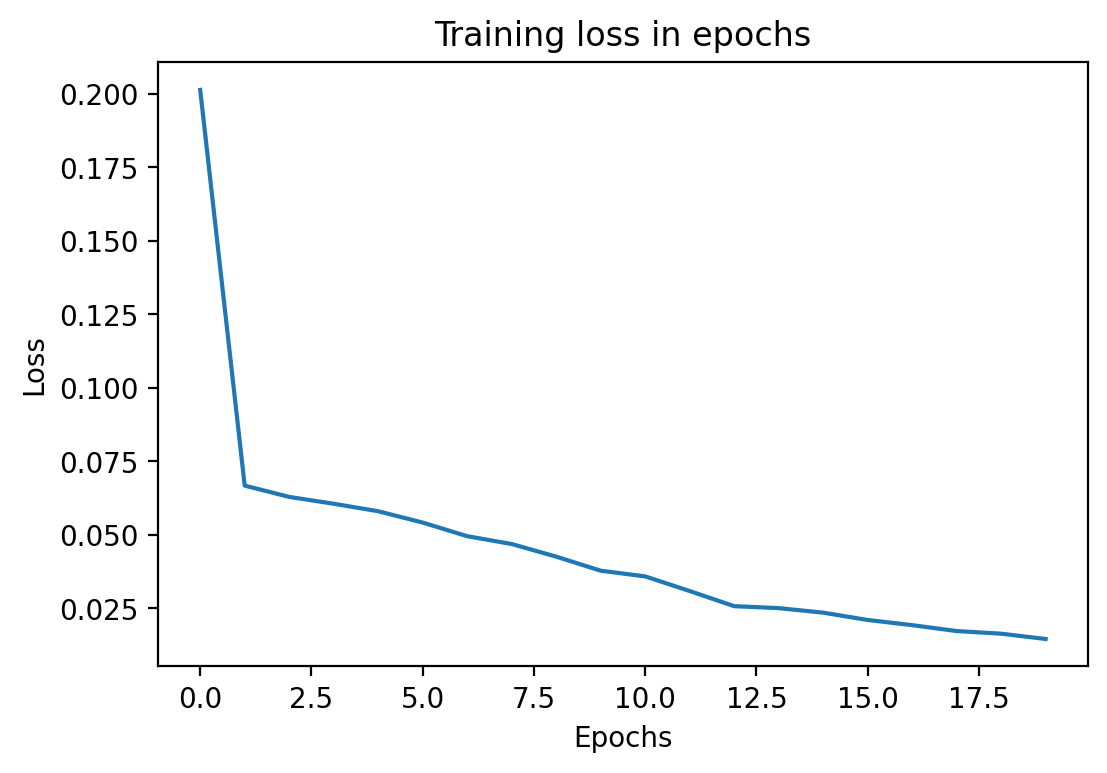

In [9]:
latent_dims = 2
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
X_short = X_train[0:3000,:,:,:]
print(X_short.shape)
vae, loss_list = train(vae, X_short)

plt.figure(2)
plt.plot(loss_list)
plt.title('Training loss in epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

(3000, 7, 1)


C:\Users\lishi\anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  after removing the cwd from sys.path.


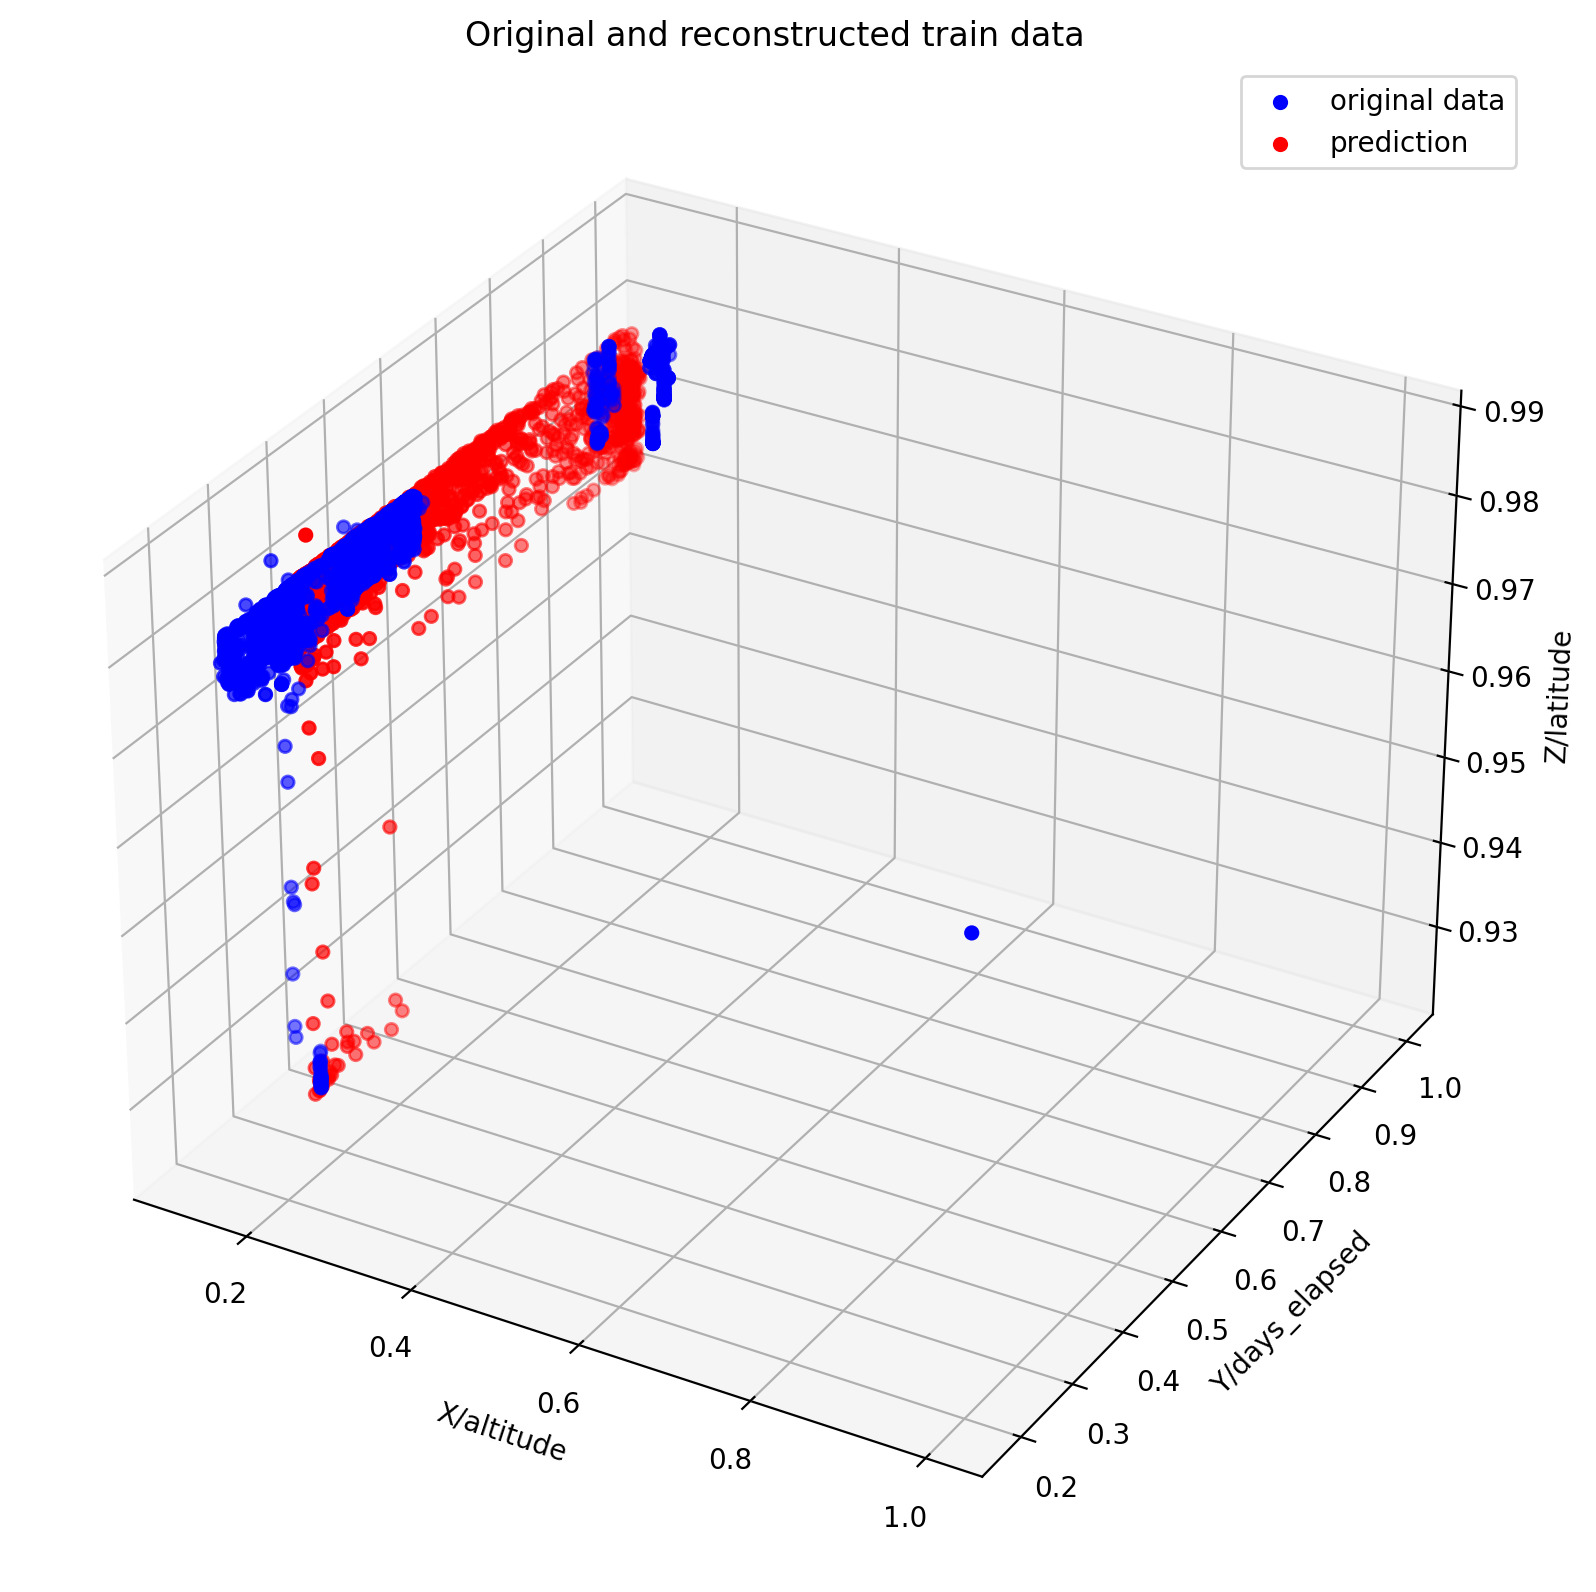

In [23]:
input_train=torch.squeeze(torch.Tensor(X_short), dim=1).detach().numpy()
print(input_train.shape)
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter(input_train[:,0,0], input_train[:,1,0], input_train[:,2,0], c='b', label = "original data");
pred_train = vae(torch.Tensor(X_short))
result_train=torch.squeeze(pred_train, dim=1).detach().numpy()
ax.scatter(result_train[:,0,0], result_train[:,1,0], input_train[:,2,0], c='r', label = "prediction");
ax.set_xlabel('X/altitude', fontsize=10)
ax.set_ylabel('Y/days_elapsed', fontsize=10)
ax.set_zlabel('Z/latitude', fontsize=10)
plt.legend()
plt.title('Original and reconstructed train data')
plt.show()

(3000, 7, 1)


C:\Users\lishi\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  """


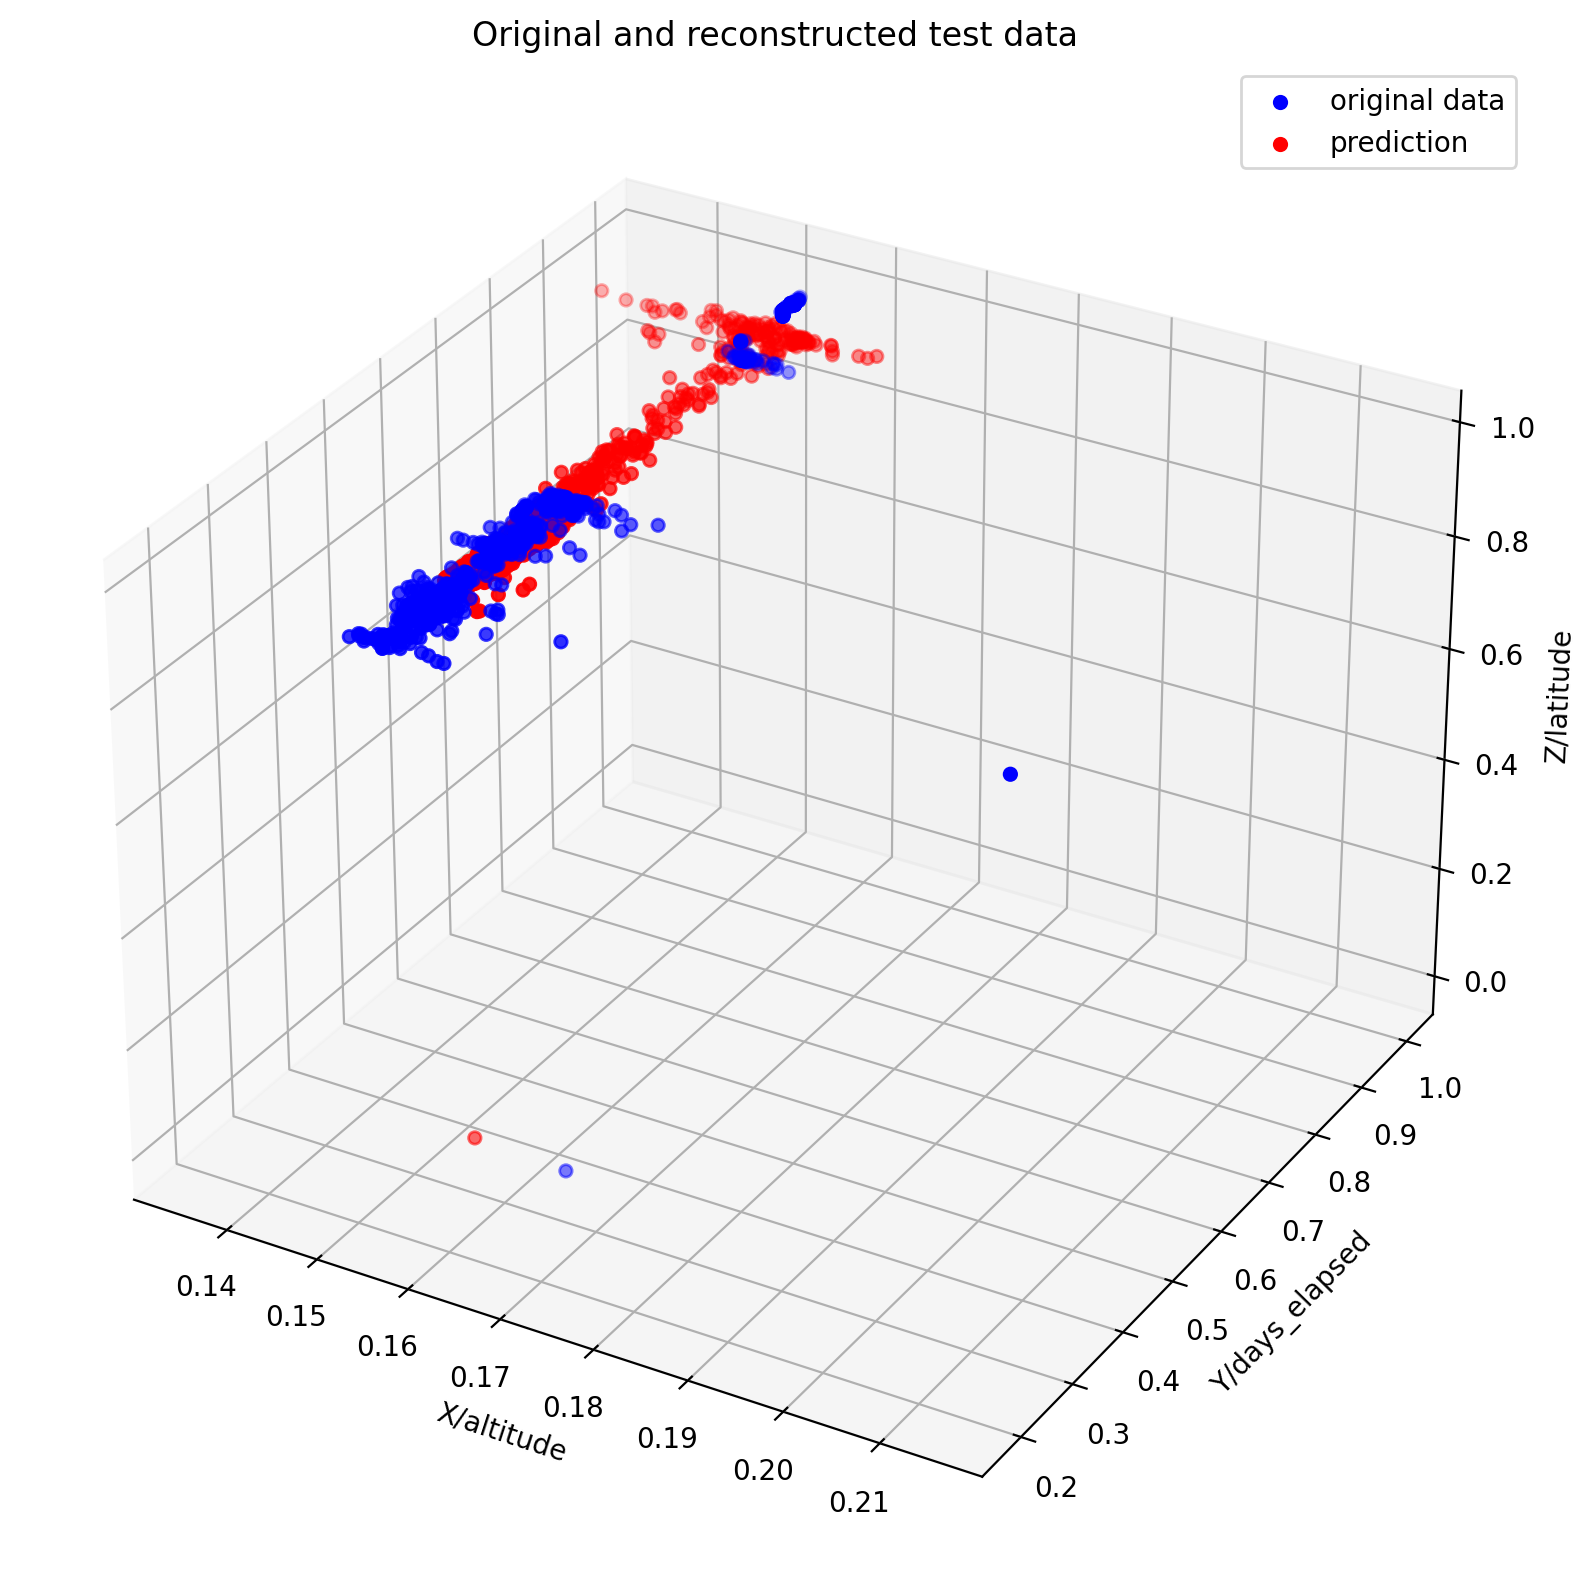

In [24]:
X_test = X_train[3001:4000,:,:,:]
input_test=torch.squeeze(torch.Tensor(X_test), dim=1).detach().numpy()
print(input_train.shape)
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter(input_test[:,0,0], input_test[:,1,0], input_test[:,2,0], c='b', label = "original data");
pred_test = vae(torch.Tensor(X_test))
result_test=torch.squeeze(pred_test, dim=1).detach().numpy()
ax.scatter(result_test[:,0,0], result_test[:,1,0], input_test[:,2,0], c='r', label = "prediction");
ax.set_xlabel('X/altitude', fontsize=10)
ax.set_ylabel('Y/days_elapsed', fontsize=10)
ax.set_zlabel('Z/latitude', fontsize=10)
plt.legend()
plt.title('Original and reconstructed test data')
plt.show()